# Motor Testing April 6th

On April 6th 2025, we took Brightside out for driving/testing for the first time since FSGP 2024.

Due to the rain, tests were conducted in the undercover parking lot nearest to EDC. While we spent most of the testing time debugging, we were able to conduct a small number of test drives.

See https://docs.google.com/document/d/1Rx3J4bNzHDbjxchzbmqbx4wmzVHT7njctfJhgrXQq_g/edit for complete details.

## Cruising Test

We conducted a very brief cruising test at 2:59PM in which we got Chris to floor the accelerator, then release it and finally brake when necessary (the parking lot is not very long).

This test was conducted under our [Cruising Test Plan](https://docs.google.com/document/d/1nRl-FxTlJjzzBGooMMIHlvJZYS2zg53nI7BmjzIfTFw/edit?tab=t.0#heading=h.x81rs6u2klim). See all STG's plans [here](https://drive.google.com/drive/u/1/folders/1l5ZTJP1LZwLBvmLuFI7MEXHikJNSyDR0).

Video: https://drive.google.com/file/d/1kIt3Dud8n91xUy1W2zfV0xKJm5OHyfYW/view?usp=drive_link


### 1. Query Data From Influx

Thanks to Aarjav for quickly uploading the Memorator data to InfluxDB on the elec bay computer.

In [16]:
from data_tools import query
from data_tools.collections import TimeSeries
from datetime import datetime, date, time, timezone

client = query.DBClient()

test_date = date(2025, 4, 6)  # April 6th, 2025
utc_offset_h = 7
cruising_test_start_utc = time(14 + utc_offset_h, 57, 40)
cruising_test_stop_utc = time(14 + utc_offset_h, 57, 58)

start_time = datetime.combine(test_date, cruising_test_start_utc, tzinfo=timezone.utc)
stop_time = datetime.combine(test_date, cruising_test_stop_utc, tzinfo=timezone.utc)

# get data for 1 minute timestamps
speed_kph: TimeSeries = client.query_time_series(start_time, stop_time, "MotorRotatingSpeed")
accelator_percent: TimeSeries = client.query_time_series(start_time, stop_time, "AcceleratorPosition")
brake_pressed: TimeSeries = client.query_time_series(start_time, stop_time, "BrakePressed")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


### 2. Plot The Data

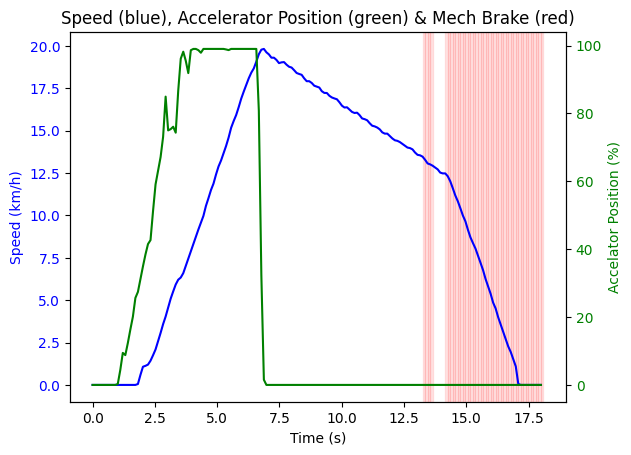

In [43]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

t_axis = speed_kph.x_axis
period = speed_kph.granularity

# Plot Speed (km/h) on the left y-axis
ax1.plot(t_axis, speed_kph, color='blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Speed (km/h)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for Accelerator Position (%)
ax2 = ax1.twinx()
ax2.plot(t_axis, accelator_percent, color='green')
ax2.set_ylabel('Accelator Position (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Change background color based on brake_pressed (1 or 0)
for i, value in enumerate(brake_pressed):
    if value == 1:
        ax1.axvspan(t_axis[i], t_axis[i]+period, color='red', alpha=0.1)  # Highlight background when brake is pressed

plt.title("Speed (blue), Accelerator Position (green) & Mech Brake (red)")

plt.show()

### 3. Save The Data

In case Influx is not available, the TimeSeries objects can be loaded from disk using ``dill``.

In [45]:
import os
import dill

out_dir = os.path.join("..", "data", "cruising_test_2025-04-06")
speed_file = os.path.join(out_dir, "speed_kph.bin")
accel_file = os.path.join(out_dir, "accelator_percent.bin")
brake_file = os.path.join(out_dir, "brake_pressed.bin")

os.makedirs(out_dir, exist_ok=True) 

for filepath, data in zip((speed_file, accel_file, brake_file),
                          (speed_kph, accelator_percent, brake_pressed)):
    with open(filepath, 'wb') as f:
        dill.dump(data, f)

### 4. And Now... Analyze!

Text(0.5, 0, 'Time (s)')

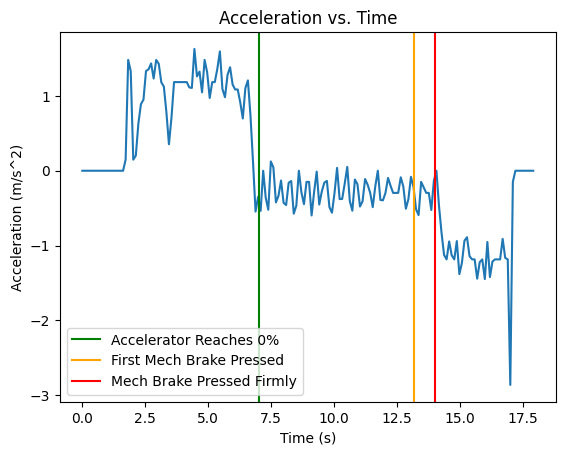

In [77]:
import numpy as np

# (kmh1 - kmh0) / period --> kmh/s
kmh_per_mps = 3.6
# acceleration is signed, meters per second squared
acceleration = (np.diff(speed_kph) / period) / kmh_per_mps
plt.plot(t_axis[:-1], acceleration)  # np.diff results in a 1 item shorter array

# label some events
t_accelerator_on_delay = 3  # roughly, seconds until the accelerator is pressed
t_accelerator_off = (np.array(accelator_percent)[int(t_accelerator_on_delay/period):]==0).argmax(axis=0) * period + t_accelerator_on_delay
t_first_brake = (np.array(brake_pressed)!=0).argmax(axis=0) * period
t_before_major_brake = 13.5  # seconds after start, time between first brake and major braking
t_major_braking = (np.array(brake_pressed)[int(t_before_major_brake/period):]!=0).argmax(axis=0) * period + t_before_major_brake

plt.axvline(t_accelerator_off, c="green", label="Accelerator Reaches 0%")
plt.axvline(t_first_brake, c="orange", label="First Mech Brake Pressed")
plt.axvline(14, c="red", label="Mech Brake Pressed Firmly")

plt.legend()

plt.title("Acceleration vs. Time")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")

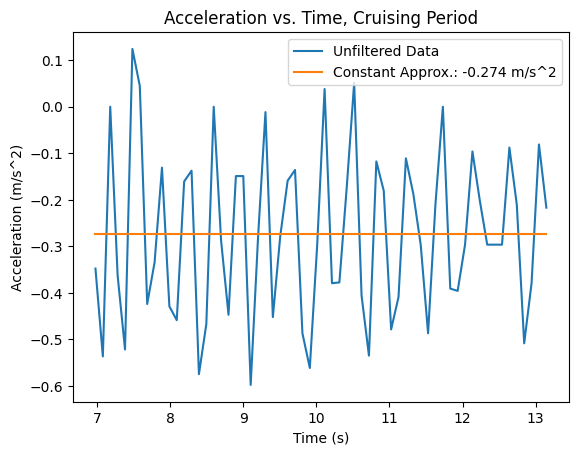

In [88]:
cruising_slice_i = int(t_accelerator_off / period)
cruising_slice_f = int(t_first_brake / period)

cruising_acceleration = acceleration[cruising_slice_i:cruising_slice_f]
cruising_t_axis = t_axis[cruising_slice_i:cruising_slice_f]

mean_cruising_acceleration = np.mean(cruising_acceleration)
contant_approx = np.ones(cruising_slice_f - cruising_slice_i) * mean_cruising_acceleration

plt.plot(cruising_t_axis, cruising_acceleration, label="Unfiltered Data")
plt.plot(cruising_t_axis, contant_approx, label=f"Constant Approx.: {mean_cruising_acceleration:.3} m/s^2")
plt.title("Acceleration vs. Time, Cruising Period")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()